In [10]:
from openeye import oechem, oequacpac, oeomega
from openmoltools import openeye
from fragmenter import utils, fragment
import os
import oenotebook as oenb
import networkx as nx
import itertools
import copy
import numpy as np
from scipy.special import comb
import networkx.algorithms.isomorphism as iso
import pandas as pd

In [2]:
# convert molecule to graph
def mol_to_graph(molecule):
    import networkx as nx
    G = nx.Graph()
    for atom in molecule.GetAtoms():
        G.add_node(atom.GetIdx(), element=atom.GetAtomicNum())
    for bond in molecule.GetBonds():
        G.add_edge(bond.GetBgnIdx(), bond.GetEndIdx(), index=bond.GetIdx())
    return G

# Check if any of the graphs are resonance structures of each others or true tautomers
def find_resonance(states):
    import networkx.algorithms.isomorphism as iso
    graphs = []
    for state in states:
        graphs.append(mol_to_graph(state)) 
    is_resonance = {}
    for i, graph in enumerate(graphs):
        found = False
        for key in is_resonance:
            if iso.is_isomorphic(graph, key):
                is_resonance[key].add(i)
                found = True
                break
        if not found:
            is_resonance[graph] = set([i])
    return is_resonance

def combine_ionization_states(expanded_states):
    """
    Seperate ionization states into seperate enetries in a dictionary keyed by the total charge of the molecule
    """
    ionization_states = {}
    for state in expanded_states:
        charge = 0
        for atom in state.GetAtoms():
            charge += atom.GetFormalCharge()
        if charge not in ionization_states:
            ionization_states[charge] = []
        ionization_states[charge].append(state)
    return ionization_states

def reasonable_resonance(molecules, ionization_state, mol_list=None, i=0):
    """
    This function finds the most reasonable resonance structures based on the minimum seperation of charge. 
    """
    if mol_list is None:
        mol_list = []
    for molecule in molecules:
        ionization_state_m = 0
        abs_charge = 0
        for atom in molecule.GetAtoms():
            ionization_state_m += atom.GetFormalCharge()
            abs_charge += abs(atom.GetFormalCharge())
        if ionization_state_m != ionization_state and i==0:
            raise Warning("ionization state of molecule is not equal to given ionization state")
        if abs_charge <= abs(ionization_state):
            mol_list.append(molecule)
    if not mol_list:
        ionization_state +=1
        i += 1
        reasonable_resonance(molecules, ionization_state, mol_list, i)
        
    return mol_list
        

In [3]:
# Generate ionization states
smiles = 'C5=C(C1=CN=CC=C1)N=C(NC2=C(C=CC(=C2)NC(C3=CC=C(C=C3)CN4CCN(CC4)C)=O)C)N=C5'
molecule = utils.smiles_to_oemol(smiles, normalize=False)
ionization_states = fragment.expand_states(molecule, stereoisomers=False, return_molecules=True)

17:00:59 INFO fragmenter: Enumerating states for 
17:00:59 INFO fragmenter: Enumerating protonation states...


In [4]:
# Check if any ionization states are resonance structures of each other
is_resonance = find_resonance(ionization_states)
# if all sets in dictionary have a length of 1, all graphs are unique
resonance = False
for graph in is_resonance:
    if len(is_resonance[graph]) > 1:
        resonance = True
print(resonance)

False


In [5]:
ionization_states = combine_ionization_states(ionization_states)

In [6]:
# For every ionization state, find tautomers and check for resonance
all_states = {}
# For the all state dict, convert everything into smiles
for charge in ionization_states:
    all_states[charge] = {}
    for mol in ionization_states[charge]:
        tautomers = fragment.expand_states(mol, protonation=False, tautomers=True, stereoisomers=False, 
                                           return_molecules=True, verbose=False, max_states=100)
        
        is_resonance = find_resonance(tautomers)
        smiles = oechem.OEMolToSmiles(mol)
        all_states[charge][smiles] = {}
        for i, tautomer in enumerate(is_resonance):
            all_states[charge][smiles]['resonance_{}'.format(i)] = [tautomers[j] for j in is_resonance[tautomer]]
            
        # If there's only one entry in the dict, then all tautomers are resonance structures of each other
        if len(is_resonance) <= 1:
            print('All tautomers are resonance of each other')
        else:
            print('New graphs were found')
            

All tautomers are resonance of each other
All tautomers are resonance of each other
All tautomers are resonance of each other
All tautomers are resonance of each other
All tautomers are resonance of each other
All tautomers are resonance of each other
All tautomers are resonance of each other
All tautomers are resonance of each other
All tautomers are resonance of each other
All tautomers are resonance of each other
All tautomers are resonance of each other
All tautomers are resonance of each other
All tautomers are resonance of each other
All tautomers are resonance of each other
All tautomers are resonance of each other
All tautomers are resonance of each other
All tautomers are resonance of each other


In [7]:
reasonable_resonance_0 = {}
for tautomer in all_states[0]:
    reasonable_resonance_structures = reasonable_resonance(all_states[0][tautomer]['resonance_0'], ionization_state=0)
    reasonable_resonance_0[tautomer] = reasonable_resonance_structures

## Depict tautomers of ionization state 0
These molecules were generated from Enumerate formal charge. These are true tautomers for the neutral molecule

,smiles,Molecule
0,Cc1ccc(cc1Nc2nccc(n2)c3cccnc3)NC(=O)c4ccc(cc4)CN5CCN(CC5)C,
1,Cc1ccc(cc1[N-]c2nccc(n2)c3ccc[nH+]c3)NC(=O)c4ccc(cc4)CN5CCN(CC5)C,
2,Cc1ccc(cc1[N-]c2nccc(n2)c3cccnc3)NC(=O)c4ccc(cc4)C[NH+]5CCN(CC5)C,
3,Cc1ccc(cc1[N-]c2nccc(n2)c3cccnc3)NC(=O)c4ccc(cc4)CN5CC[NH+](CC5)C,

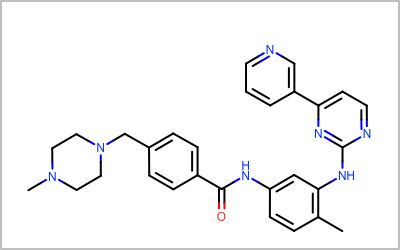
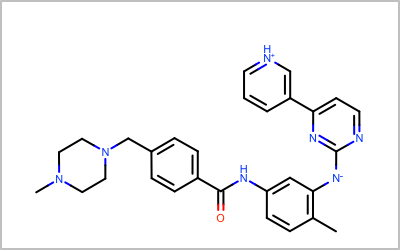
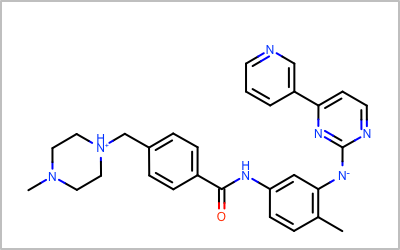
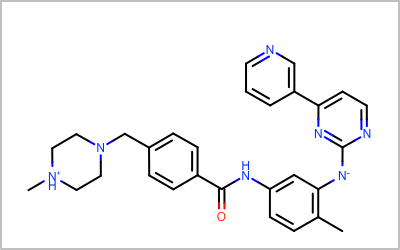

In [8]:
def get_mol(smiles):
    m = oechem.OEMol()
    oechem.OESmilesToMol(m, smiles)
    return m
tautomers_0 = list(reasonable_resonance_0.keys())
mol_dict = {'smiles': tautomers_0}
df = pd.DataFrame(mol_dict)
df['Molecule'] = df['smiles'].apply(get_mol)

oenb.render_dataframe(df)

## Tautomers generated from each ionization state
I wanted to check if the tautomer enumerated frome each molecule will find the other tautomers. 
In the first cell, I'm depicting the tautomers generated from molecule 0 in the above image. As you can see,
the piperazine did not get protonated while other nitrogens did. 

,Molecule
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,

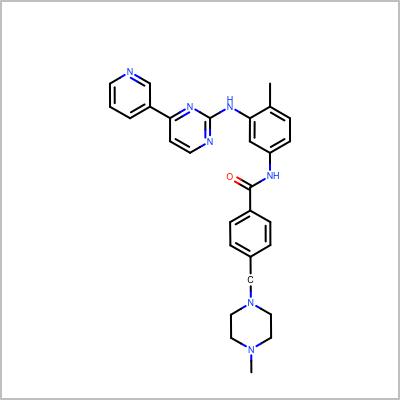
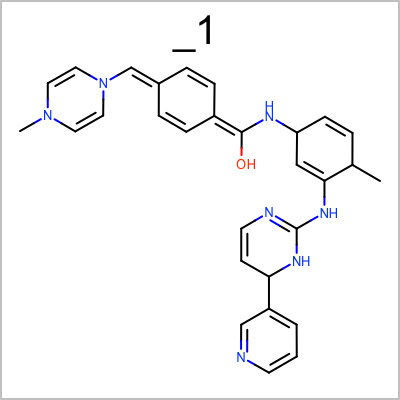
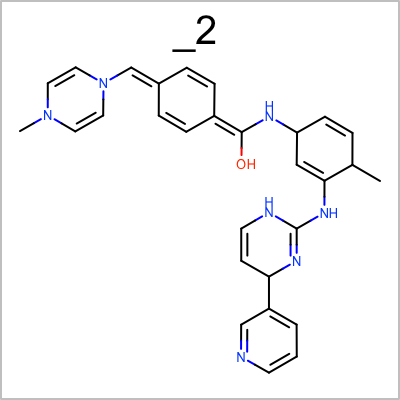
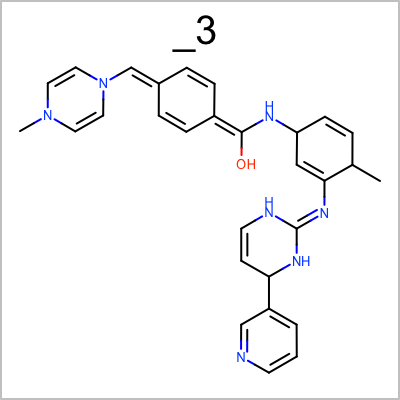
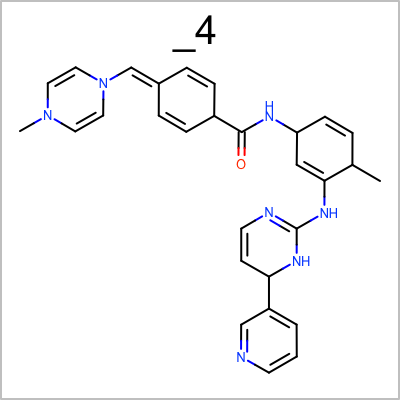
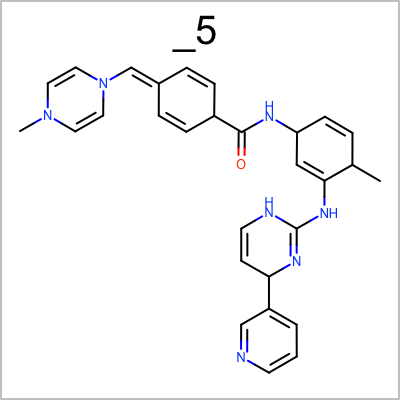
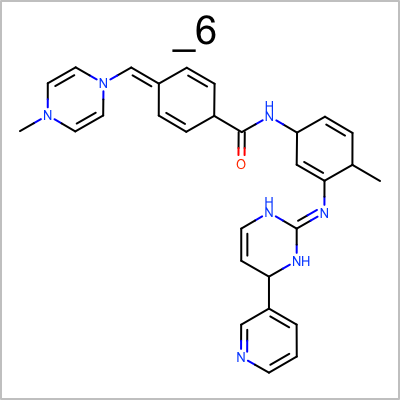
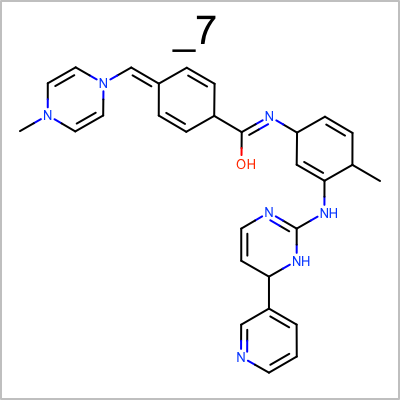
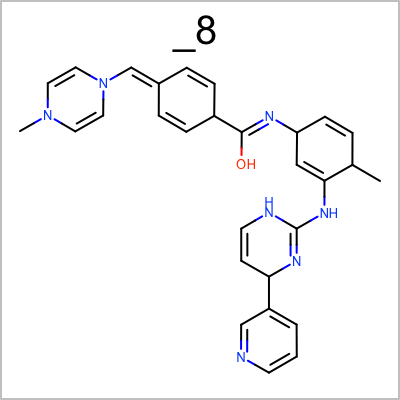
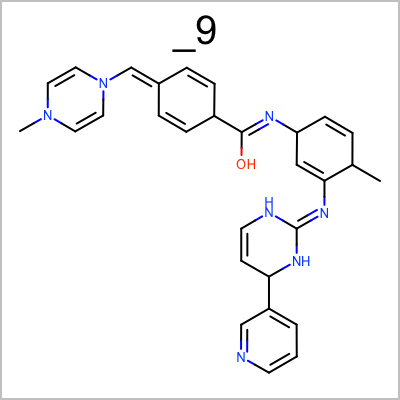
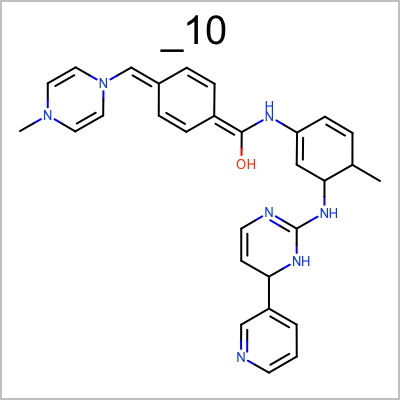
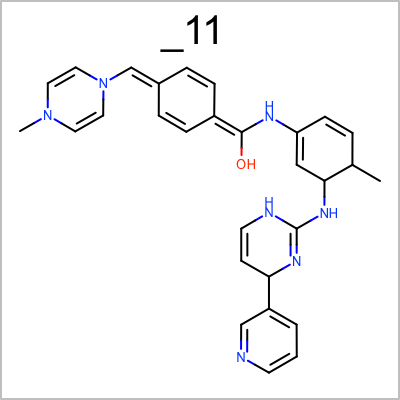
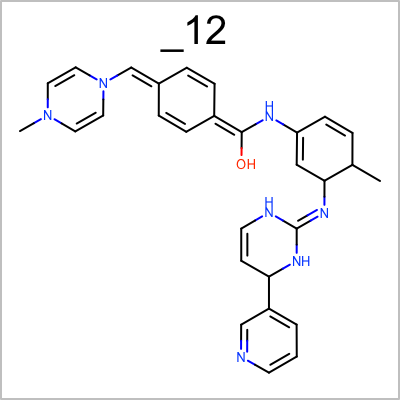
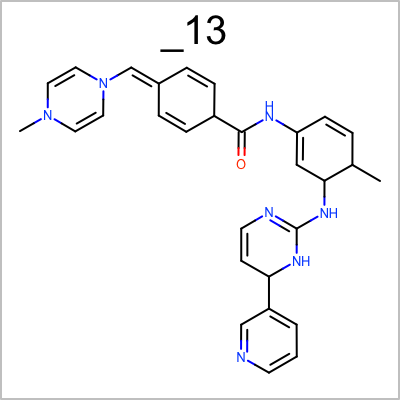
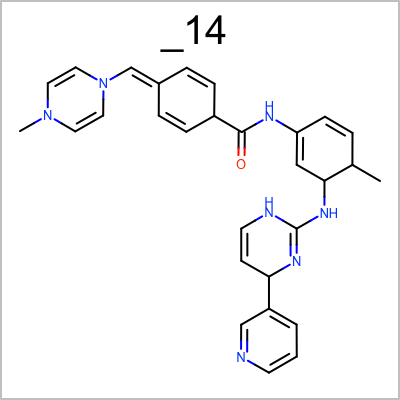
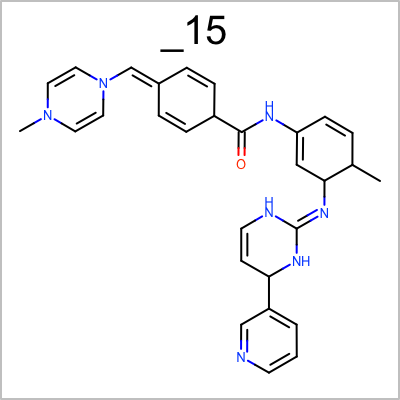
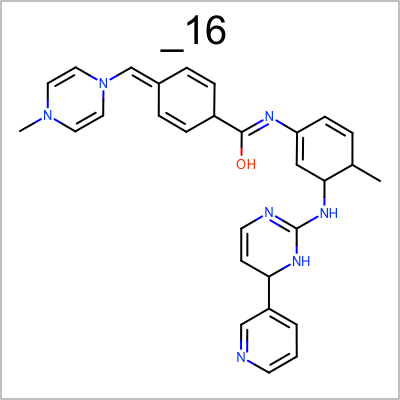
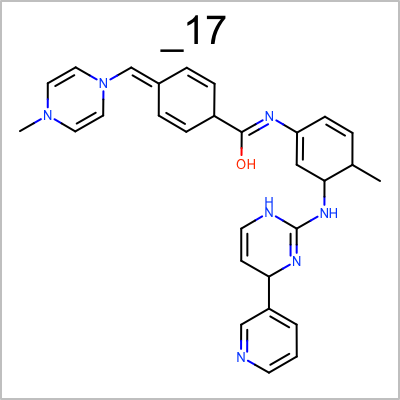
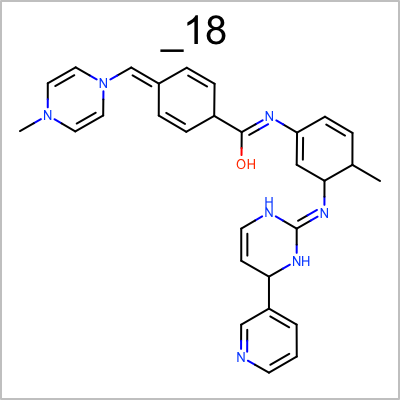
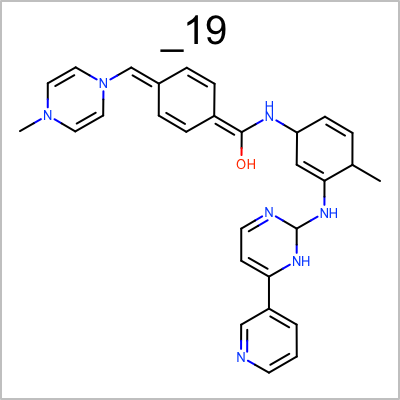
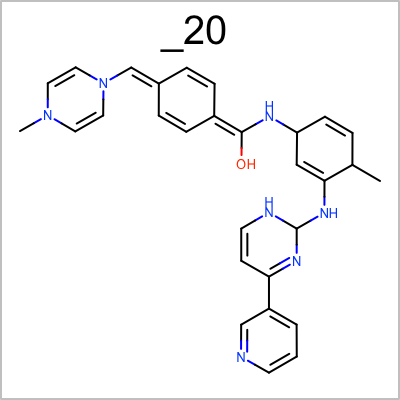
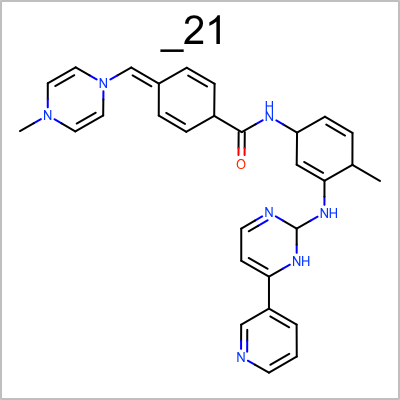
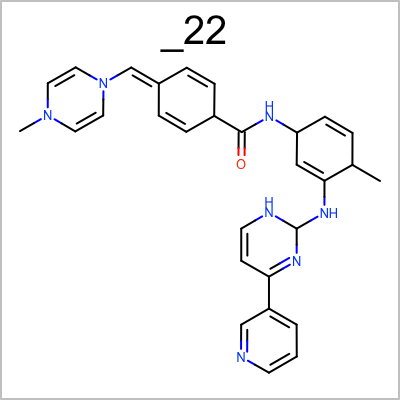
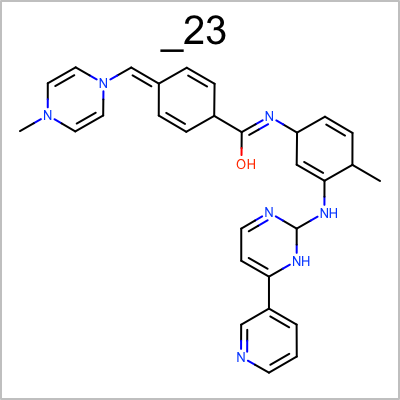
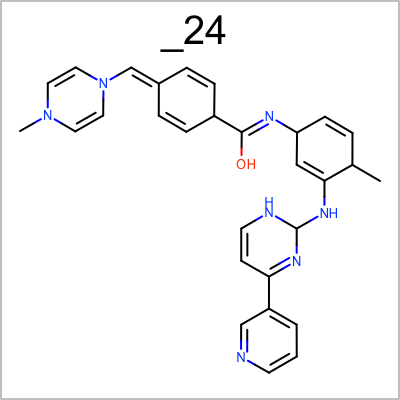
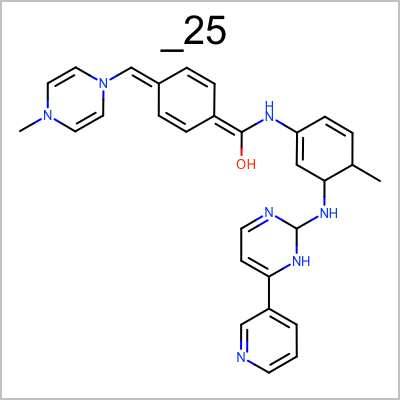
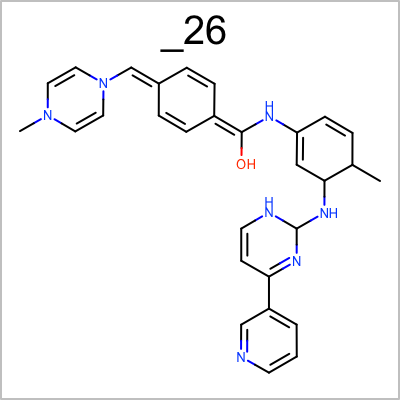
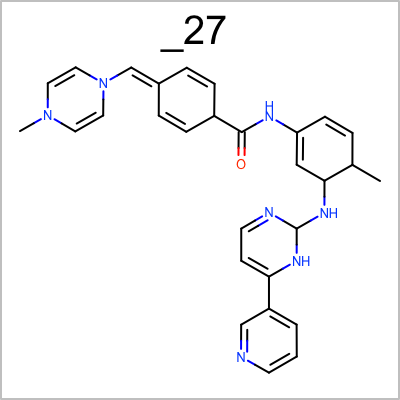
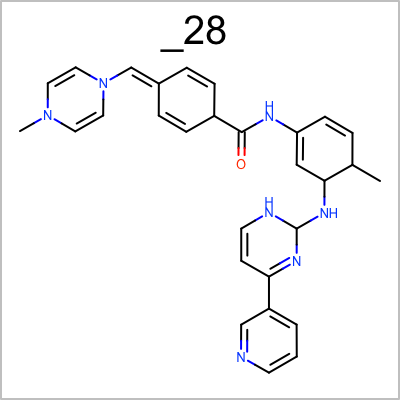
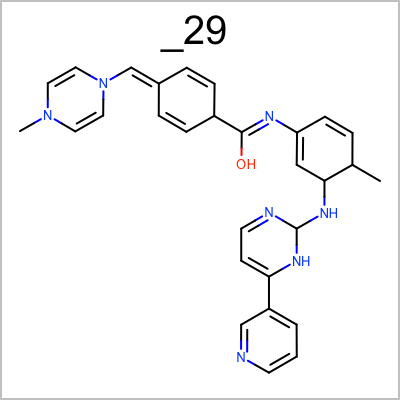
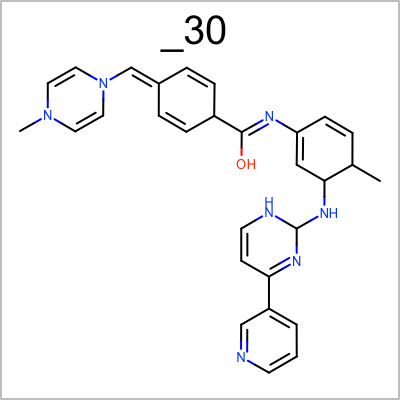
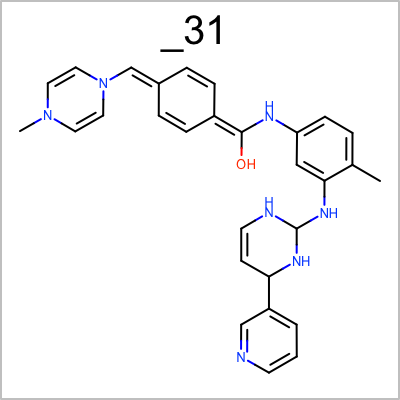
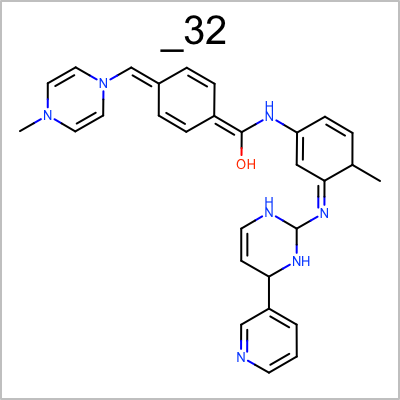
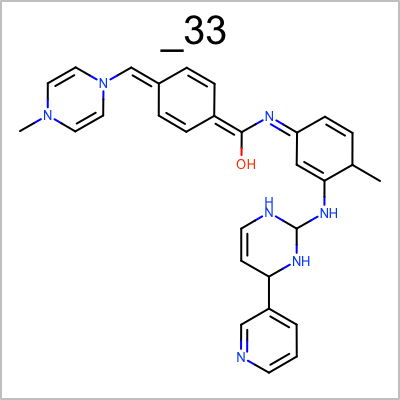
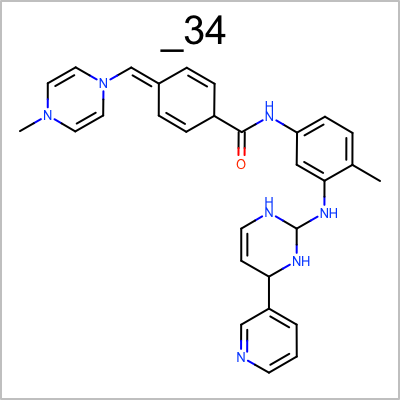
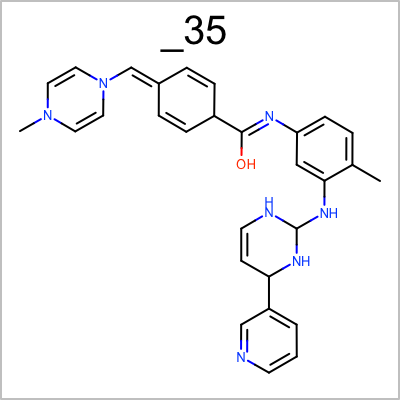
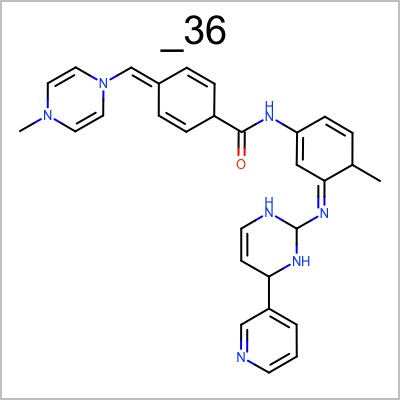
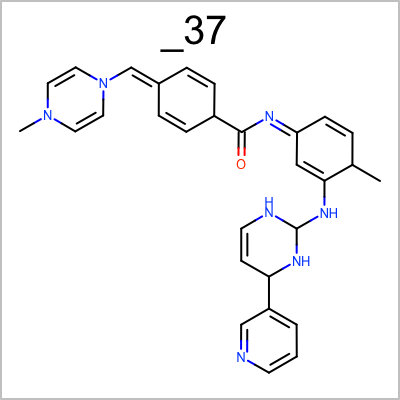
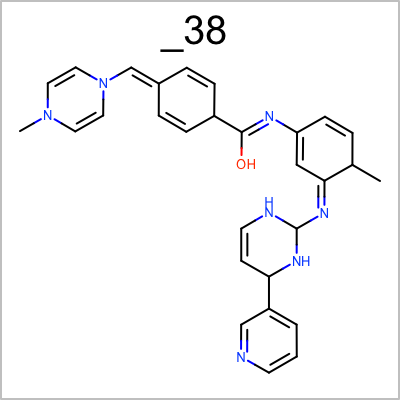
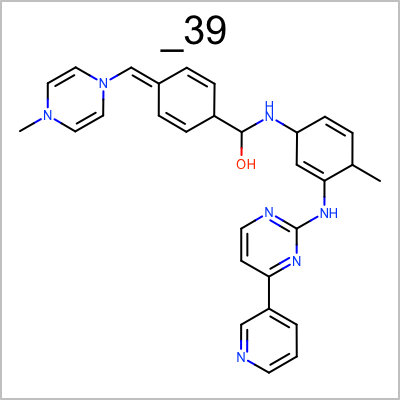
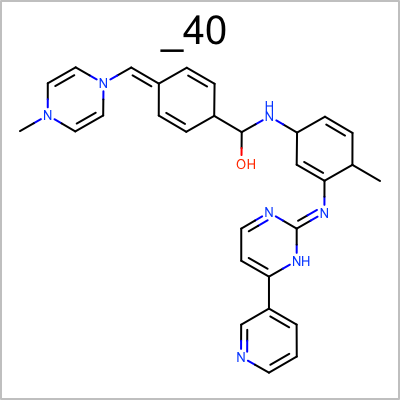
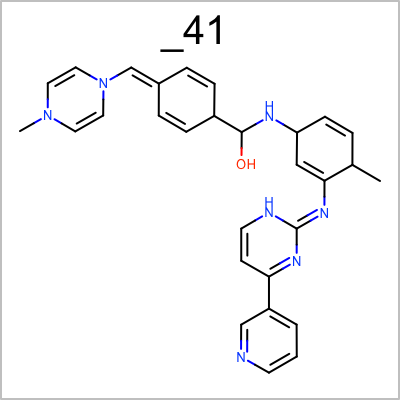
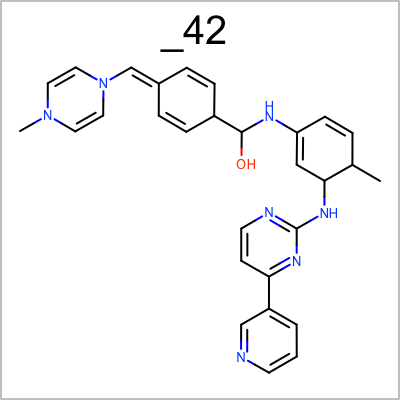
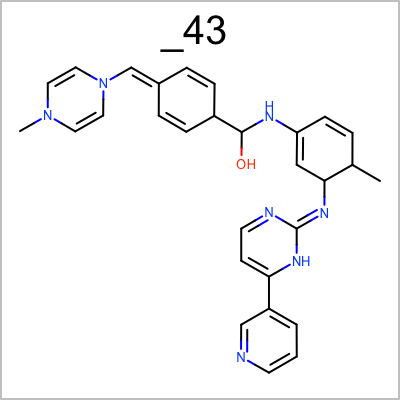
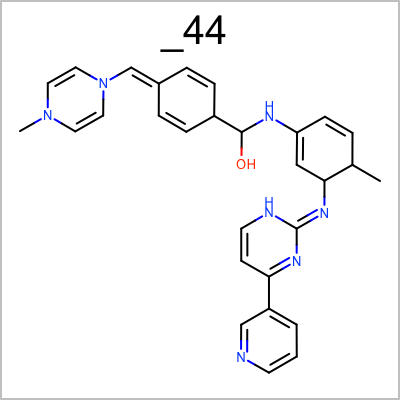
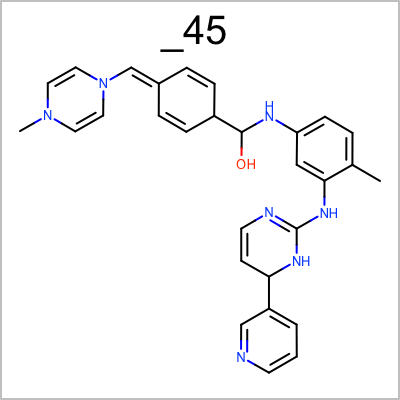
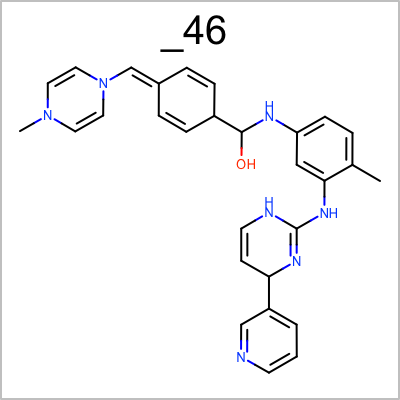
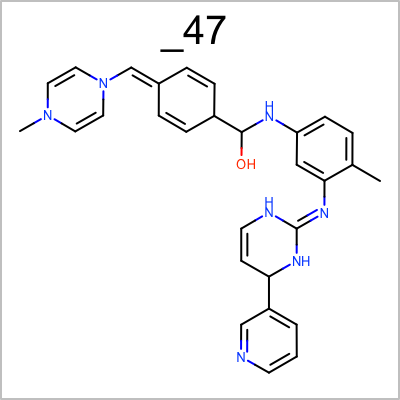
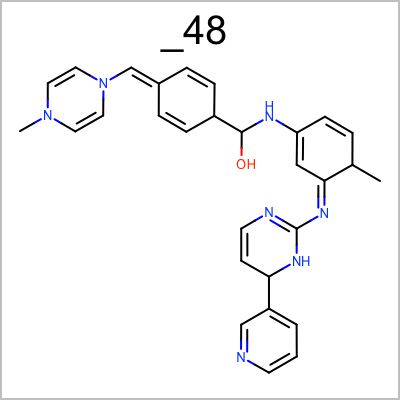
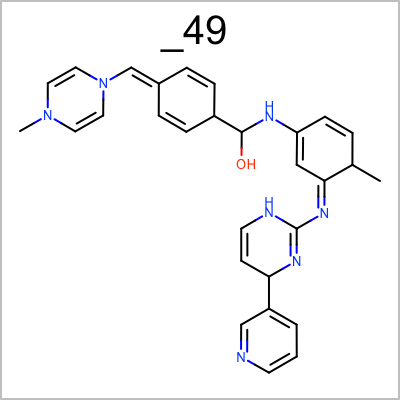
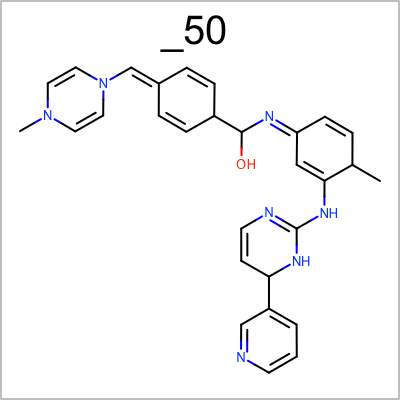
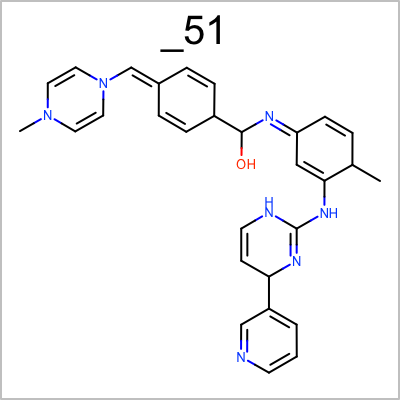
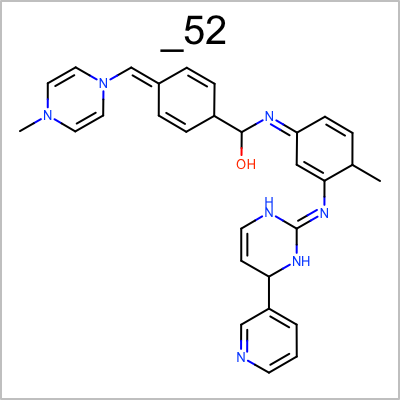
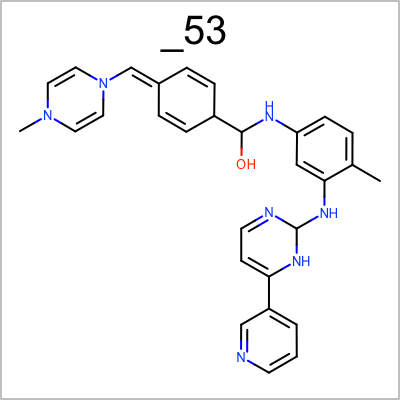
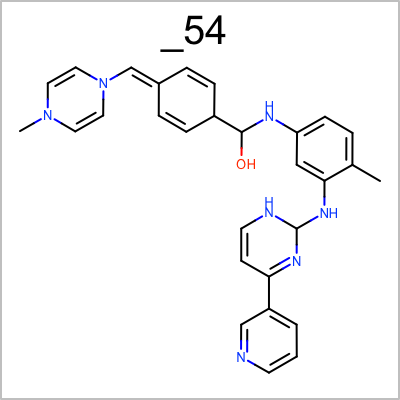
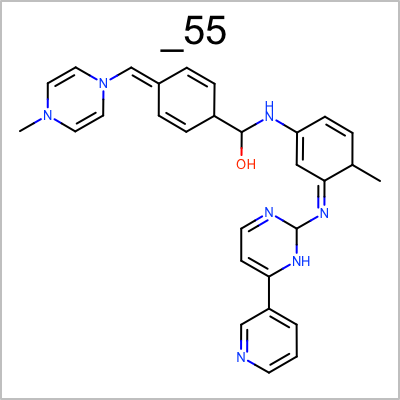
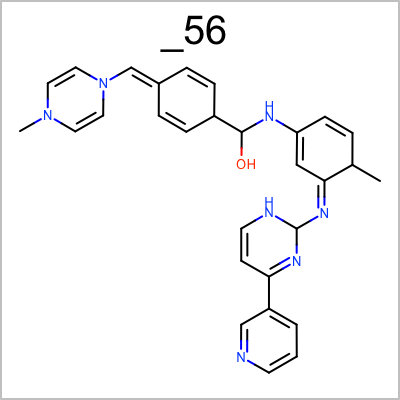
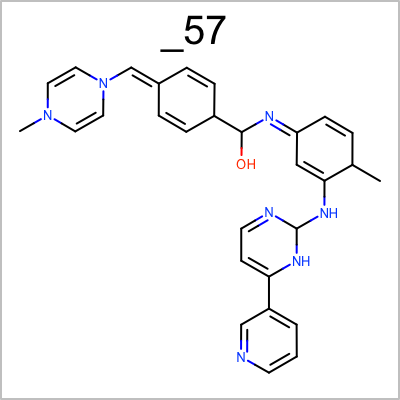
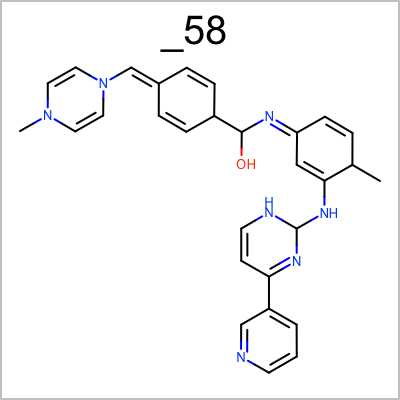
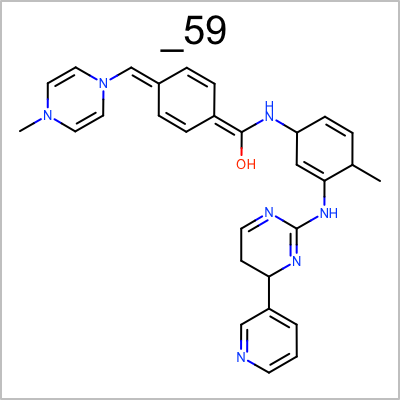
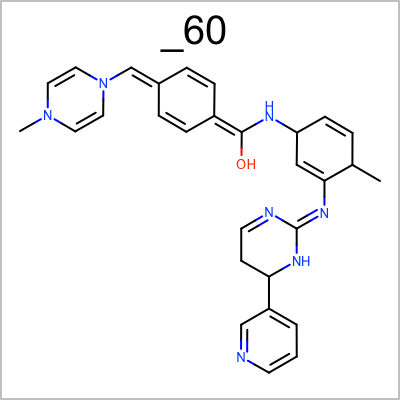
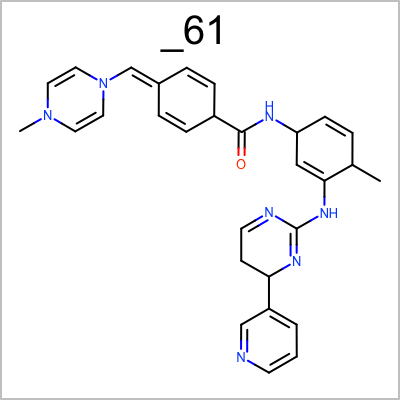
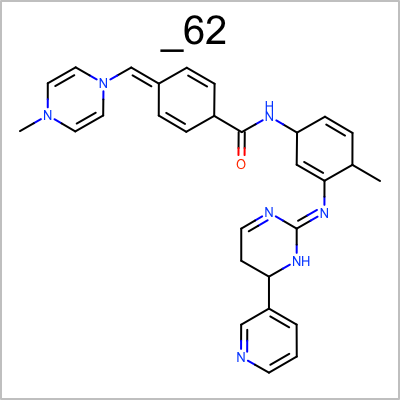
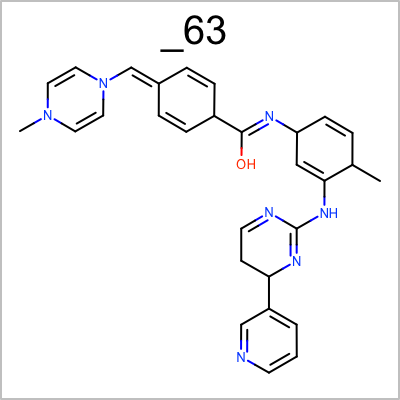
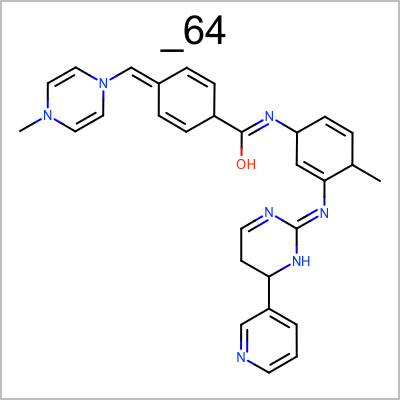
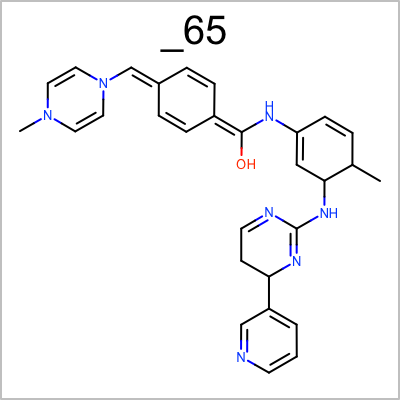
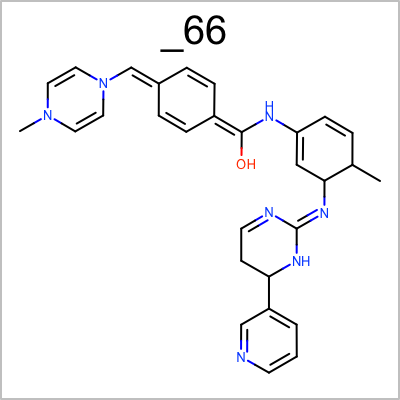
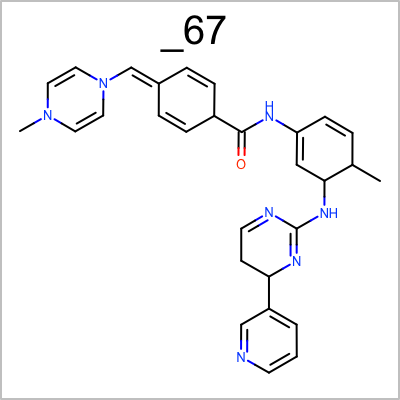
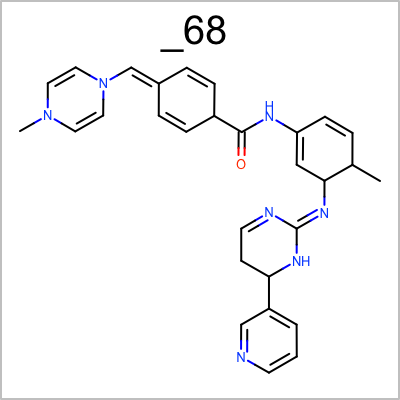
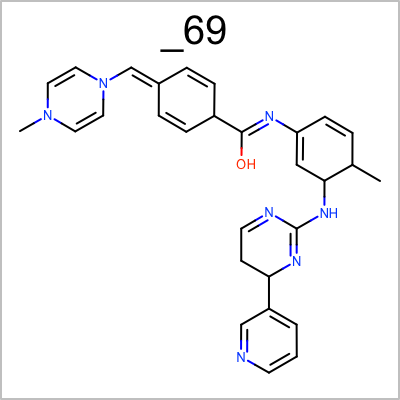
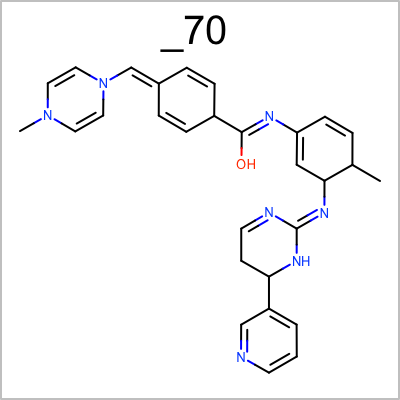
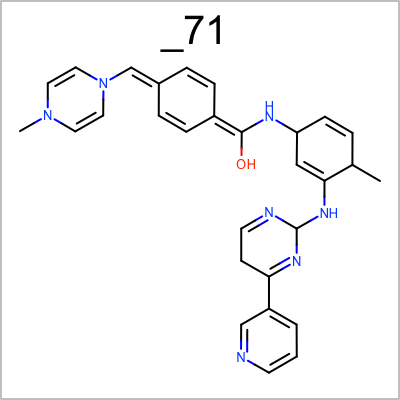
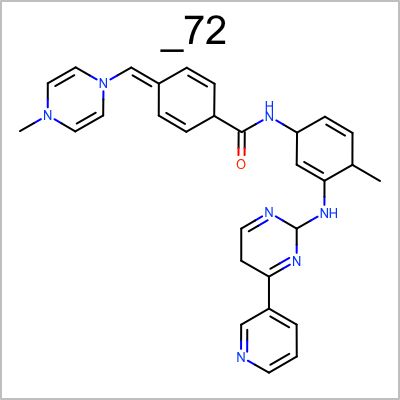
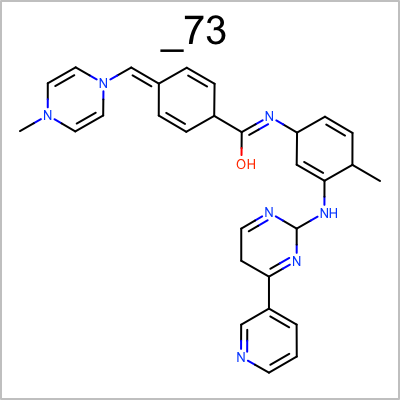
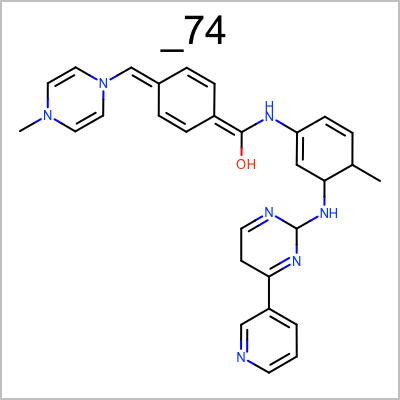
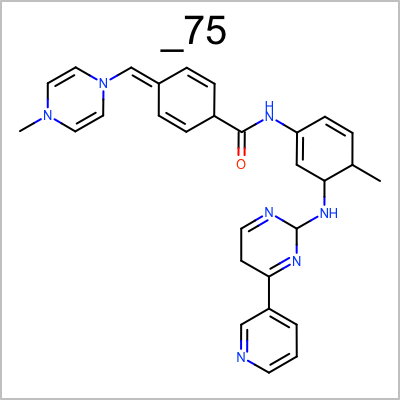
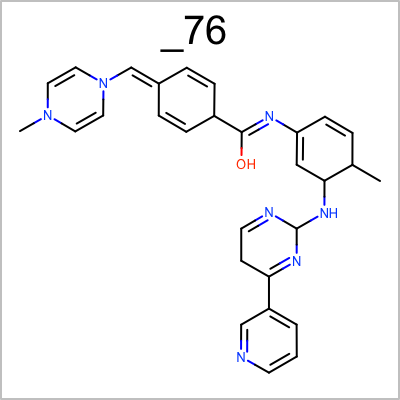
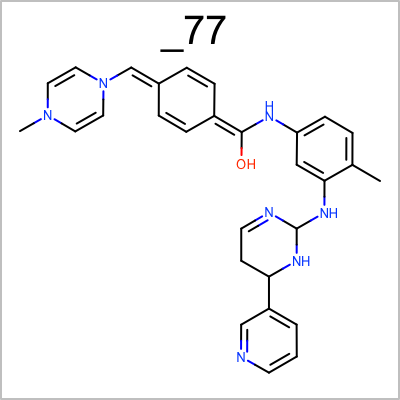
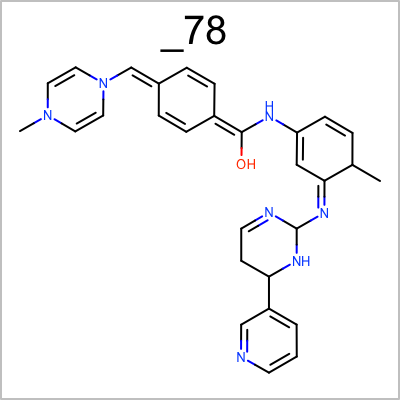
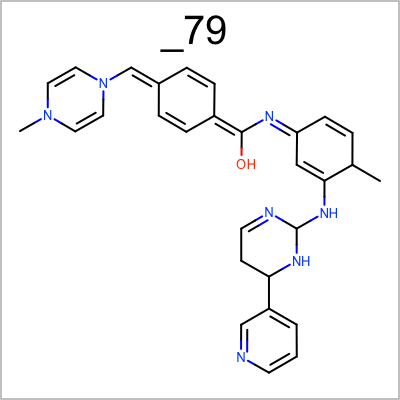
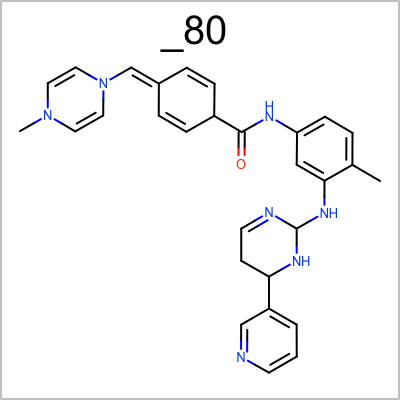
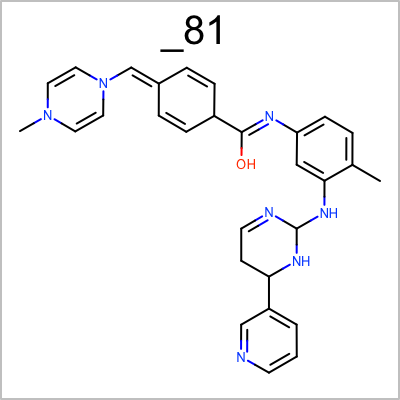
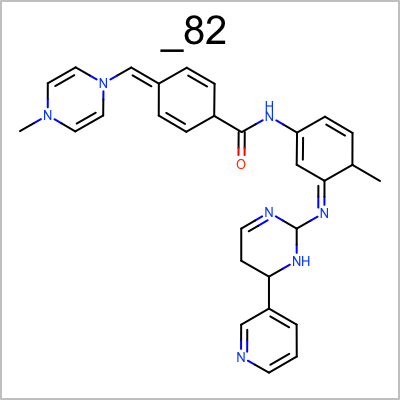
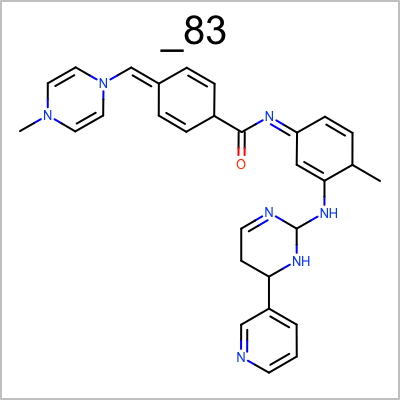
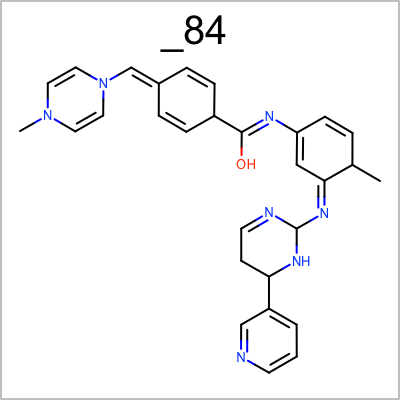
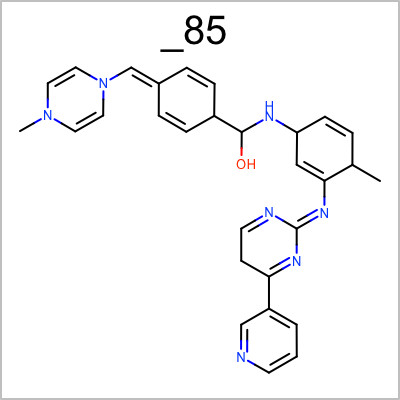
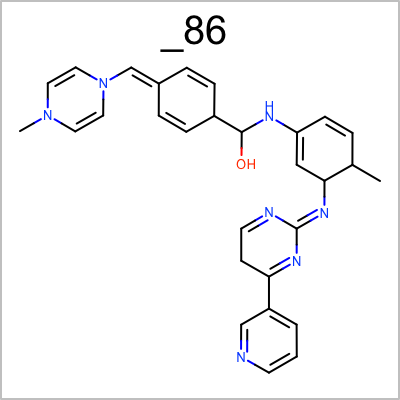
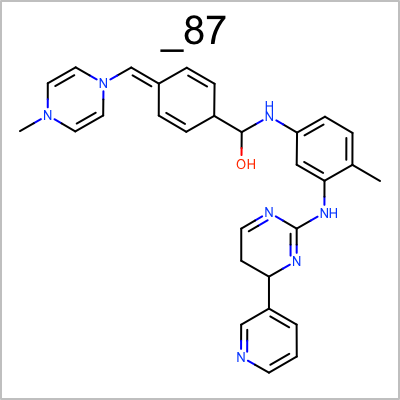
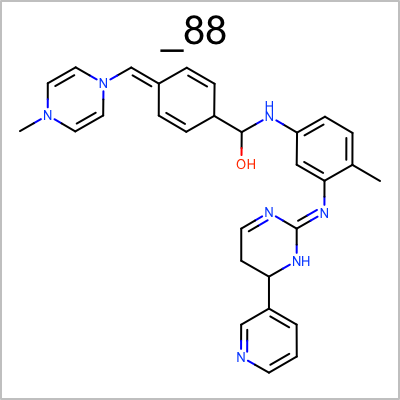
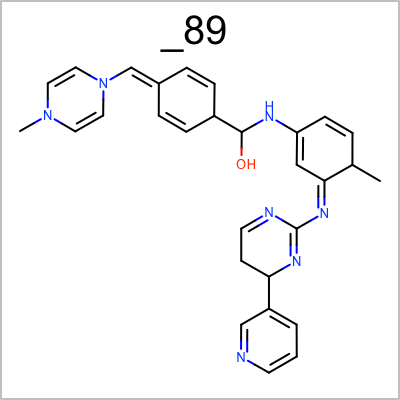
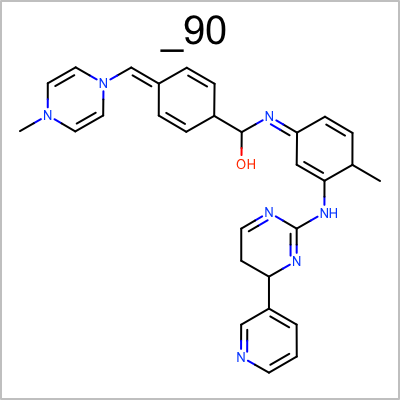
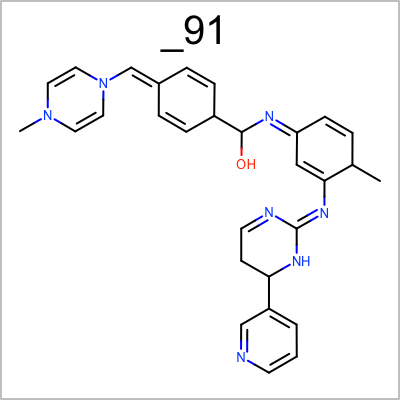
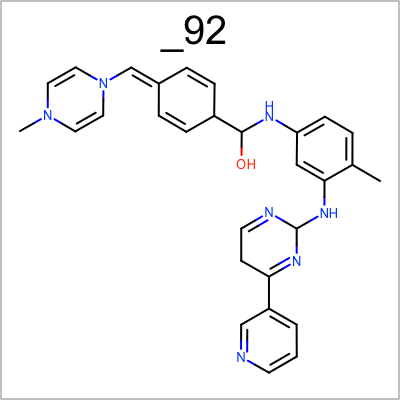
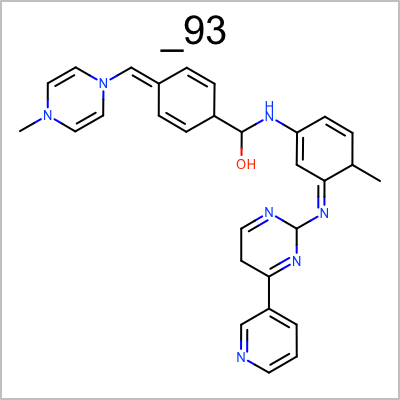
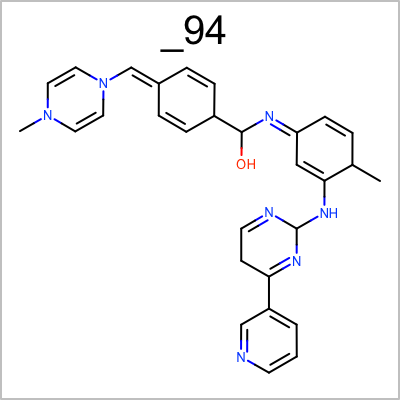
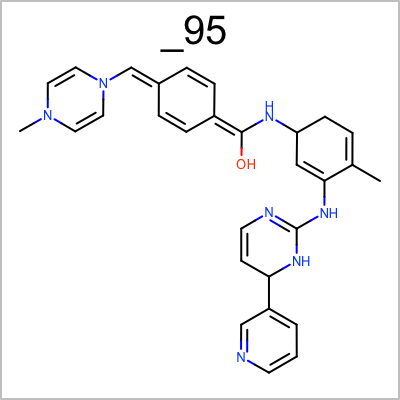
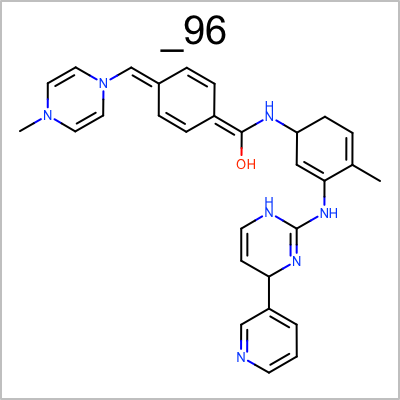
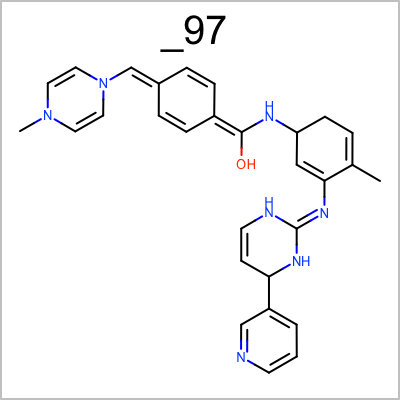
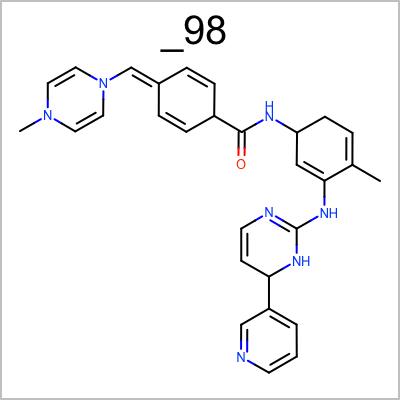
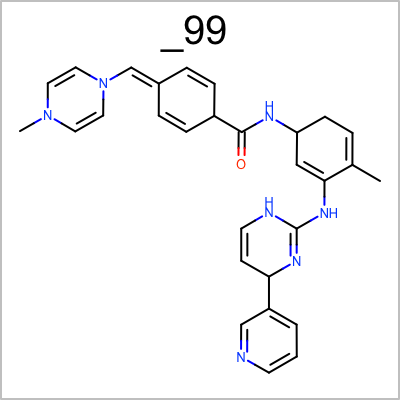
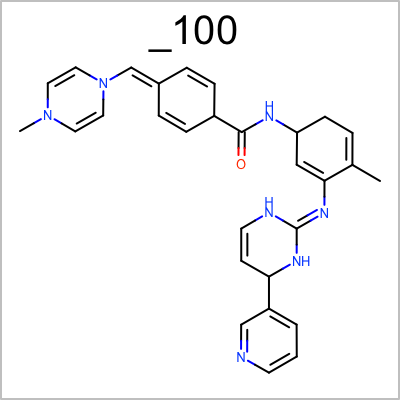

In [9]:
# Depict reasonable resonance structures of tautomers
reasonable_resonance_0
mol_dict = {'Molecule': reasonable_resonance_0[tautomers_0[0]]}
df = pd.DataFrame(mol_dict)
#df['Molecule'] = df['smiles'].apply(get_mol)

oenb.render_dataframe(df, height=400, width=400)

## Tautomers enumerated for a protonated piperazine
For the tautomers generated for Imatinib where piperazine was protonated, the proton does not move to other sites, even in the piperazine 

,Molecule
0,
1,
2,
3,
4,
5,
6,
7,

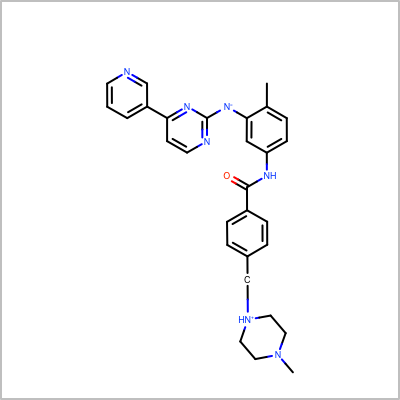
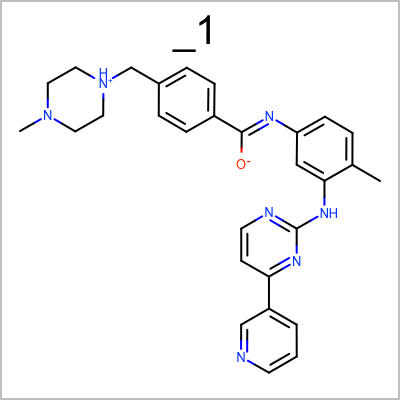
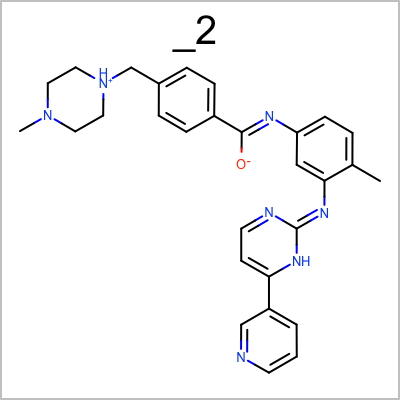
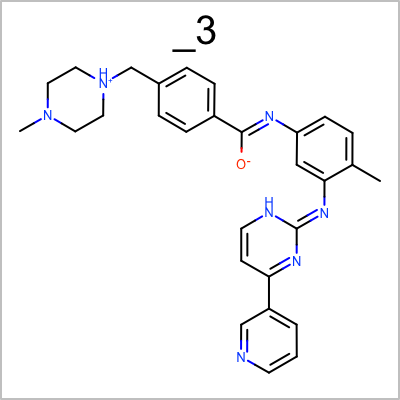
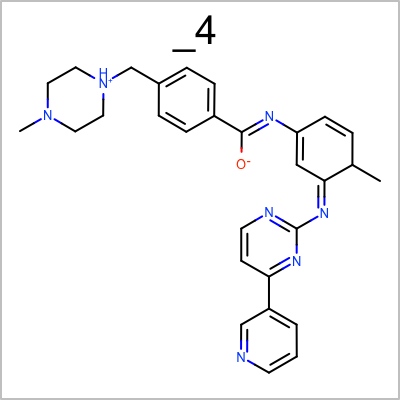
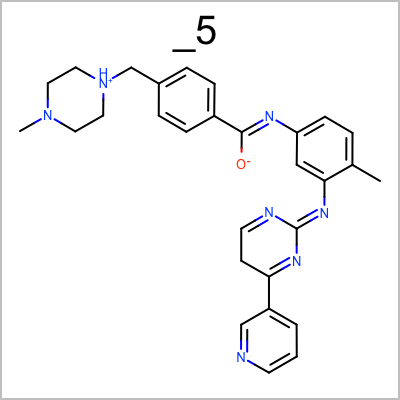
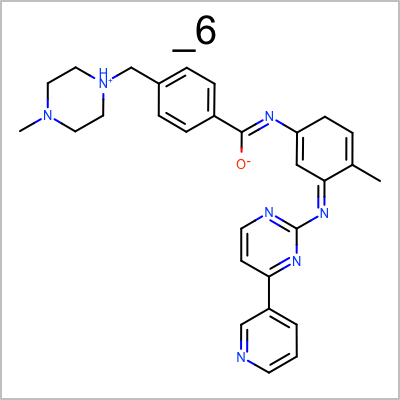
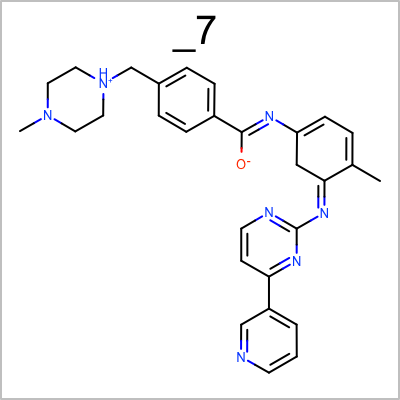

In [13]:
# Depict reasonable resonance structures of tautomers
reasonable_resonance_0
mol_dict = {'Molecule': reasonable_resonance_0[tautomers_0[2]]}
df = pd.DataFrame(mol_dict)
#df['Molecule'] = df['smiles'].apply(get_mol)

oenb.render_dataframe(df, height=400, width=400)